# Optimization of Locations for Charging Stations
* Objective: minimizing total cost (cost of installing chargers + cost of travelling between charge point and destination)
* Demand at all places need to be satisfied.
* Charging capacity is not surpassed at each charging station. <br><br>
* The optimization problem is summarized as: 
$$\min \sum^m_{j=1}f_j y_j + \sum^n_i \sum^m_j c_{ij}x_{ij}$$
$$ s.t.\ \sum^m_{j=1}x_{ij} = d_i,\ \ \ \ i = 1,...,n$$
$$ \ \ \ \ \ \sum^n_{i=1}x_{ij} \leqslant M_j y_j, \ \ \ \ j = 1,...,m$$
$$ \ \ \ \ \ x_{ij}\leqslant d_i y_j, \ \ \ \ i = 1,...,n$$
$$ \ \ \ x_{ij}\geqslant 0 $$
$$ \ \ \ y_j \in \{0,\ 1\}$$
where $f_j$ = fixed cost of charging station at location $j$,  
$y_j \in \{0,1\}$ indicates whether to build a charging station at location $j$,  
$c_{ij}$ is the travel cost for person at desired destination location $i$ to charging station at location $j$,  
$x_{ij}$ is the demand of charging by person at location $i$ that will be covered by charging station at location $j$,  
$d_i$ is demand of charging at destination location $i$.



In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopy.distance import great_circle
from scipy.spatial import distance
from pulp import *
import gmplot
os.chdir('/Users/chengchen/Desktop/Insight/project/')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


In [16]:
df_demand = pd.read_excel('data/cleaned/optimization_CT_AM_trips_cluster.xlsx')
df_parking= pd.read_excel('data/cleaned/optimization_parking_location_cluster.xlsx')
df_parking

,latitude,longitude,Rating,Name,Url,ID,ward,cluster
0,43.788048,-79.276242,3.8,Agincourt Recreation Centre,https://maps.google.com/?cid=14455393119458858291,ChIJuRi7_XDR1IkRM5X4RXTfm8g,Ward 41,10
1,43.795021,-79.267795,3.3,Commander Park Arena,https://maps.google.com/?cid=2414437274109840855,ChIJofioV2vR1IkR143Hl-jNgSE,Ward 41,10
2,43.801973,-79.169251,3.7,Camargue II,https://maps.google.com/?cid=10691051525845621433,ChIJX8tImyLa1IkRuRptGbg-XpQ,Ward 44,20
3,43.804325,-79.168983,2.8,Meadowvale Rd At Dean Park Rd,https://maps.google.com/?cid=8392916872116906985,ChIJ1Xzefyba1IkR6Svpd22heXQ,Ward 44,20
4,43.805632,-79.137119,4.2,Glen Rouge Campground,https://maps.google.com/?cid=18340315983353479452,ChIJTTTWR9_b1IkRHAE0ODfkhf4,Ward 44,8
5,43.806137,-79.180519,5.0,Sheppard Ave East At Dean Park Rd,https://maps.google.com/?cid=4230099767868564282,ChIJd-VC2R7a1IkROqNErFNVtDo,Ward 44,20
6,43.767099,-79.157181,4.8,XYZ Storage Scarborough,https://maps.google.com/?cid=7908541703541928901,ChIJm_ET-_7a1IkRxbP6MsfIwG0,Ward 44,8
7,43.768773,-79.177527,4.5,Heron Park Arena,https://maps.google.com/?cid=334935952690568365,ChIJGQEt7fTa1IkRrdygcnnupQQ,Ward 44,20
8,43.769010,-79.175870,4.2,Heron Park Community Centre,https://maps.google.com/?cid=10866556311505152286,ChIJowQH5_Ta1IkRHikLT2TDzZY,Ward 44,20
9,43.770810,-79.173965,3.5,Toronto Police Service 43 Division,https://maps.google.com/?cid=6509192044725283107,ChIJBQiSqVja1IkRIymmcK1LVVo,Ward 44,20


In [17]:
df_parking['local_id'] = np.arange(len(df_parking))
df_demand['local_id']=np.arange(len(df_demand))

In [18]:
cluster_list = [i for i in range(40)]


In [19]:
def gen_sets(cluster_id, df_demand, df_parking):
    """Generate sets to use in the optimization problem"""
    # set of charging demand locations (destinations)
    df_demand_cls = df_demand.loc[df_demand['parking_cluster'] == cluster_id]
    demand_lc = df_demand_cls.index.tolist()
    # set of candidates for charging station locations (currently existing parking lots)
    df_parking_cls = df_parking.loc[df_parking['cluster'] == cluster_id]
    chg_lc = df_parking_cls.index.tolist()
    return demand_lc, chg_lc
demand_lc, chg_lc = gen_sets(cluster_list[0], df_demand, df_parking)


#### Cost of each charging station
Assume each charging station has 5 level II chargers, the cost of installing the chargers in the parking lot is approximately 11000$.  
https://www.homeadvisor.com/cost/garages/install-an-electric-vehicle-charging-station/#level2

####  Charging Capacity of each charging station
Here we only consider the situation of level II charging which is the most common public charging type. It can fully charge an electric car within 4-6 hours. It is ideal to use this type of charging service while working or doing some other activities nearby during day time. The full capacity of each charging station with 5 level II chargers would be fully charging 10 cars.

#### Cost of driving/walking from/to charging stations
This cost will be proportional to distance between charging station location and charging demand (destination) location. Assume travel cost is 2 dollars per 1km for each trip, assume 250 day trips are made to the charging station, interest rate = 3%, amortization period = 3 years, then the present value of travel cost per 1km away from the charging station is 500+500/1.03+500/(1.03^2) = 1457 dollars

In [20]:
def gen_parameters(cluster_id, df_demand, df_parking):
    """Generate parameters to use in the optimization problem, 
    including capacity of charging station, cost to install charging stations, 
    and travel costs to and from the charging stations (present value)"""
    # fixed cost to install a charging station with 5 level II chargers
    df_parking_cls = df_parking.loc[df_parking['cluster'] == cluster_id].copy()
    df_parking_cls['fixed_cost'] = 11000
    fixed_cost = df_parking_cls['fixed_cost'].to_dict()
    
    # capacity: 5 chargers, with each charger charging 4 cars at most per day
    df_parking_cls['chg_capacity'] = 20
    capacity = df_parking_cls['chg_capacity'].to_dict()
    
    # distance matrix of charging station location candidates and charging demand location
    
    coords_pk = [(x,y) for x,y in zip(df_parking_cls['longitude'],df_parking_cls['latitude'])]
    df_demand_cls = df_demand.loc[df_demand['parking_cluster']==cluster_id]
    coords_trip = [(x,y) for x,y in zip(df_demand_cls['long'],df_demand_cls['lat'])]

    distance_matrix = distance.cdist(coords_pk, coords_trip, 'euclidean')
    transfer_ratio = 85
    distance_matrix2 = transfer_ratio*distance_matrix
    df_distance = pd.DataFrame(distance_matrix2, index = df_parking_cls.index.tolist() ,columns = df_demand_cls.index.tolist())
    df_travel_cost = df_distance * 1457
    dic_cost_matrix = df_travel_cost.to_dict('index')
    
    
    #df_distance = pd.read_excel('data/cleaned/distance_mtx_'+ward+'.xlsx')
    #df_travel_cost = df_distance * 1457
    #dic_cost_matrix = df_travel_cost.to_dict('index')
    return fixed_cost, capacity, dic_cost_matrix
fixed_cost, capacity, dic_cost_matrix = gen_parameters(1, df_demand, df_parking)    

* To see more statistics of Toronto's commute distance pattern, please see https://www150.statcan.gc.ca/n1/pub/75-006-x/2019001/article/00008-eng.htm
* charging demand ratio is defined by number of electric cars that requires public charging divided by number of automobile trips made. This ratio equals electric car peneration ratio (how much percentage of cars are electric) times how much percentage of electric cars need to be charged. Assumptions here include: (1)Longer commute trips (trips from outside of the city) will always require charging; (2) shorter commute trips won't require charging if home charging is available; (3) shorter commute without access to home charging will require public charging once every five times.
* Charging demand ratio = EV Penetration Ratio(Longer_Commute_ratio + (1-Longer_commute_ratio)*(1-Home Charging Ratio)/5)
* EV Penetration Ratio and Home Charging Ratio will come from user input, as these numbers vary with time and can be drawn from future surveys. Longer commute ratio is set at 10%. (i.e., Assume that 10% of traffic into the city of Toronto are from outside of the city.) 


In [21]:
def gen_demand(df, demand_ratio, column = 'CT_AM_trips'):
    """generate the demand for charging (during day time) for each census tract"""
    df1 = df.copy()
    df1['demand_chg'] = df1[column]*demand_ratio
    df1 = df1.round({'demand_chg':0})
    return df1
#long_commute_ratio = 0.1
#df_demand = gen_demand(demand_ward1, EVPR, home_chg_ratio)
# round the demand_chg to be integer so that it's easier to calculate
# need to modify the code so that it rounds automatically
#df_demand['demand_chg'] = 1
#df_demand

In [22]:
# create a list that iterates all possible combinations of EVPR and homg_chg_ratio and return resulted EVPR*pr_ch
# need to carefully define long_commute ratio
# allow home charging ratio to range between 0.5 and 0.9
# allow EVPR to range between 0.01 to 0.2
# maximum of demand ratio would be: 0.2*(0.1*1+0.9*0.5/5) = 0.038
# minimum of demand ratio would be: 0.01*(0.1*1+0.9*0.1/5) = 0.00118
list_demand_ratio = np.linspace(0.00118, 0.038, num=30).tolist()
# list_demand_ratio
# will iterate through the 20 numbers below to plot the map with optimal locations of stations
# because the optimization process takes about 3 - 5 minutes per iteration, 
# I prepare the results of optimization for the webapp

In [23]:
def optimize_cls(cluster_id, df_demand, df_parking, demand_ratio):
    demand_lc, chg_lc = gen_sets(cluster_id, df_demand, df_parking)
    fixed_cost, capacity, dic_cost_matrix = gen_parameters(cluster_id, df_demand, df_parking)
    df_demand_cls = df_demand.loc[df_demand['parking_cluster'] == cluster_id]
    df_demand = gen_demand(df_demand_cls, demand_ratio)
    demand = df_demand['demand_chg'].to_dict()
    # set up the optimization problem
    prob = LpProblem('FacilityLocation', LpMinimize)
    serv_vars = LpVariable.dicts("Service",
                                 [(i,j) for i in demand_lc
                                        for j in chg_lc],
                                  0)
    use_vars = LpVariable.dicts("UseLocation", chg_lc, 0, 1, LpBinary)
    prob += lpSum(fixed_cost[j]*use_vars[j] for j in chg_lc) + lpSum(dic_cost_matrix[j][i]*serv_vars[(i,j)] for j in chg_lc for i in demand_lc)
    for i in demand_lc:
        prob += lpSum(serv_vars[(i,j)] for j in chg_lc) == demand[i] # constraint 1
    for j in chg_lc:
        prob += lpSum(serv_vars[(i,j)] for i in demand_lc) <= capacity[j]*use_vars[j]
    for i in demand_lc:
        for j in chg_lc:
            prob += serv_vars[(i,j)] <= demand[i]*use_vars[j]
    print(cluster_id)
    prob.solve()
    print("Status: ", LpStatus[prob.status])
    TOL = .00001
    opt_location = []
    for i in chg_lc:
        if use_vars[i].varValue > TOL:
            opt_location.append(i)
            print("Eslablish charging station at site", i)
    df_status = pd.DataFrame({"cluster": [cluster_id], "status": [LpStatus[prob.status]], "N_chg": [len(opt_location)]})
    return opt_location, df_status
        
opt_location, df_status = optimize_cls(1, df_demand, df_parking, list_demand_ratio[0])

1
Status:  Optimal
Eslablish charging station at site 514


In [24]:
def df_to_gdf(df):
    """takes a dataframe with columns named 'longitude' and 'latitude' 
    to transform to a geodataframe with point features"""
    
    df['coordinates'] = df[['longitude', 'latitude']].values.tolist()
    df['coordinates'] = df['coordinates'].apply(Point)
    df = gpd.GeoDataFrame(df, geometry = 'coordinates')
    return df
#gdf_optimal_parking = df_to_gdf(df_opt_chg_lc)

0
Status:  Infeasible
Eslablish charging station at site 30
Eslablish charging station at site 36
Eslablish charging station at site 46
Eslablish charging station at site 47
Eslablish charging station at site 48
Eslablish charging station at site 50
Eslablish charging station at site 51
Eslablish charging station at site 52
Eslablish charging station at site 53
Eslablish charging station at site 54
Eslablish charging station at site 55
Eslablish charging station at site 56
Eslablish charging station at site 57
Eslablish charging station at site 58
Eslablish charging station at site 122
1
Status:  Optimal
Eslablish charging station at site 507
Eslablish charging station at site 508
Eslablish charging station at site 509
Eslablish charging station at site 510
Eslablish charging station at site 511
Eslablish charging station at site 512
Eslablish charging station at site 513
Eslablish charging station at site 514
Eslablish charging station at site 515
2
Status:  Optimal
Eslablish charging

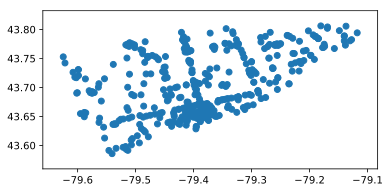

In [25]:
def main_map_generater(demand_ratio, df_demand, df_parking, cluster_list):
    opt_chg_location = []
    df_output_status = pd.DataFrame(columns = ['cluster', 'status', 'N_chg'])
    for cluster_id in cluster_list:
        opt_location, df_status = optimize_cls(cluster_id, df_demand, df_parking, demand_ratio)
        opt_chg_location += opt_location
        df_output_status =df_output_status.append(df_status)
    df_output_status.to_excel('data/processed/chg_stn_status_cluster_demand_ratio'+str(demand_ratio)[2:]+'.xlsx')
    df_opt_chg_lc = df_parking.ix[opt_chg_location]
    df_opt_chg_lc.to_excel('data/processed/chg_stn_location_cluster_demand_ratio'+str(demand_ratio)[2:]+'.xlsx')
    gdf_optimal_parking = df_to_gdf(df_opt_chg_lc)
    gdf_optimal_parking.plot()
    plt.savefig('graphs/location_cluster_demand_ratio_'+str(demand_ratio)[2:]+'.jpg')
    gmap1 = gmplot.GoogleMapPlotter(43.72, -79.4, 12 ) 
    gmap1.apikey = 'My_key'
    latitude_list = gdf_optimal_parking.latitude.tolist()
    longitude_list = gdf_optimal_parking.longitude.tolist()
    gmap1.scatter(latitude_list, longitude_list, 'green',size = 30, marker = True)
    gmap1.draw( 'graphs/gmplot/map_cluster_demand_ratio_'+str(demand_ratio)[2:]+'.html') 
    return df_output_status, gdf_optimal_parking
df_output_status, gdf_optimal_parking = main_map_generater(0.02,df_demand, df_parking, cluster_list)    

demand ratio =  0.00118
0
Status:  Optimal
Eslablish charging station at site 30
Eslablish charging station at site 53
Eslablish charging station at site 57
1
Status:  Optimal
Eslablish charging station at site 514
2
Status:  Optimal
Eslablish charging station at site 496
Eslablish charging station at site 592
3
Status:  Optimal
Eslablish charging station at site 117
4
Status:  Optimal
Eslablish charging station at site 153
Eslablish charging station at site 155
Eslablish charging station at site 204
5
Status:  Optimal
Eslablish charging station at site 283
Eslablish charging station at site 315
6
Status:  Optimal
Eslablish charging station at site 195
Eslablish charging station at site 197
7
Status:  Optimal
Eslablish charging station at site 133
8
Status:  Optimal
Eslablish charging station at site 4
9
Status:  Optimal
Eslablish charging station at site 382
Eslablish charging station at site 421
10
Status:  Optimal
Eslablish charging station at site 1
Eslablish charging station at si

/Users/chengchen/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


progress:  20
demand ratio =  0.027842758620689655
0
Status:  Infeasible
Eslablish charging station at site 30
Eslablish charging station at site 36
Eslablish charging station at site 46
Eslablish charging station at site 47
Eslablish charging station at site 48
Eslablish charging station at site 50
Eslablish charging station at site 51
Eslablish charging station at site 52
Eslablish charging station at site 53
Eslablish charging station at site 54
Eslablish charging station at site 55
Eslablish charging station at site 56
Eslablish charging station at site 57
Eslablish charging station at site 58
Eslablish charging station at site 122
1
Status:  Infeasible
Eslablish charging station at site 507
Eslablish charging station at site 508
Eslablish charging station at site 509
Eslablish charging station at site 510
Eslablish charging station at site 511
Eslablish charging station at site 512
Eslablish charging station at site 513
Eslablish charging station at site 514
Eslablish charging sta

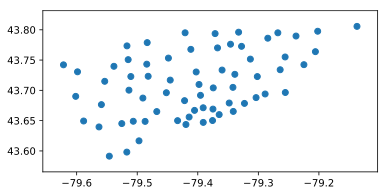

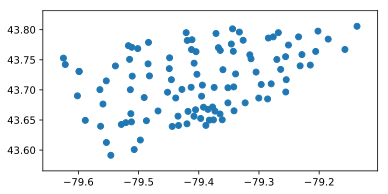

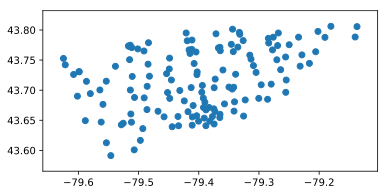

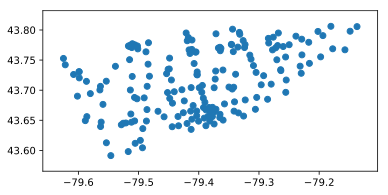

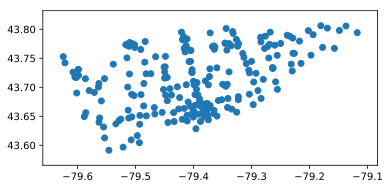

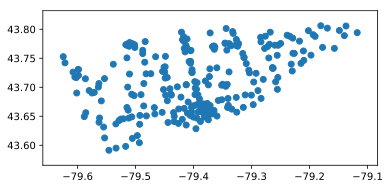

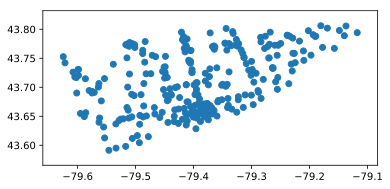

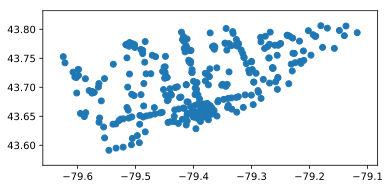

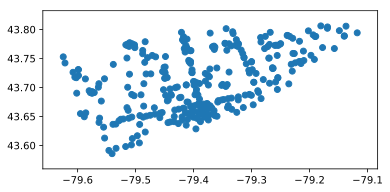

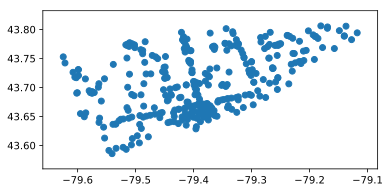

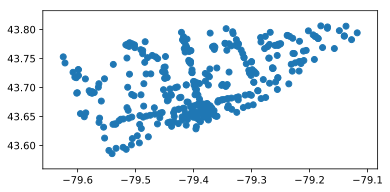

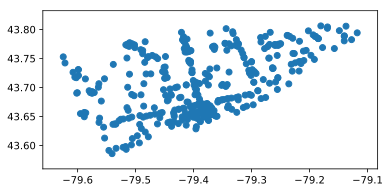

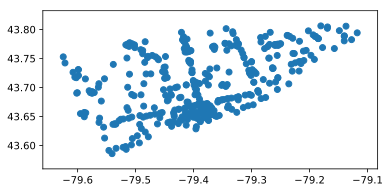

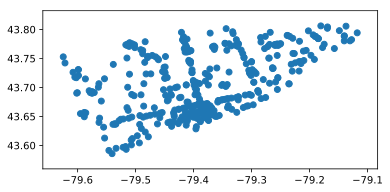

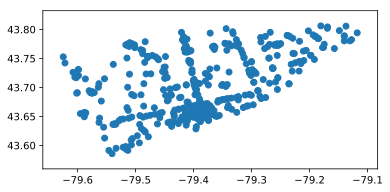

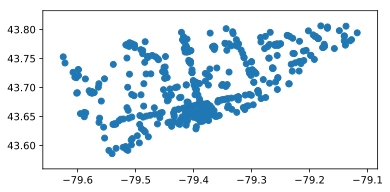

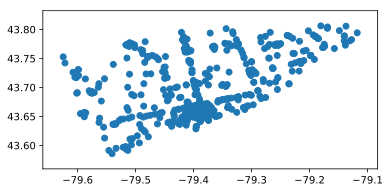

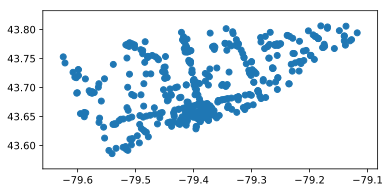

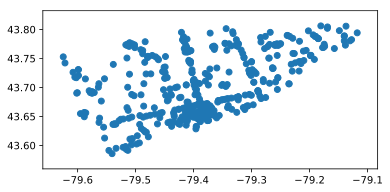

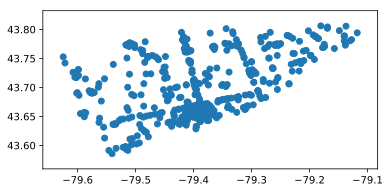

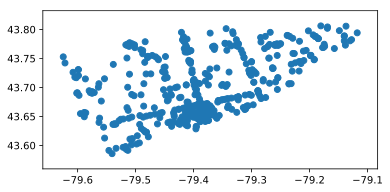

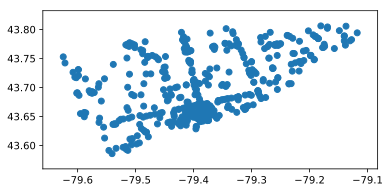

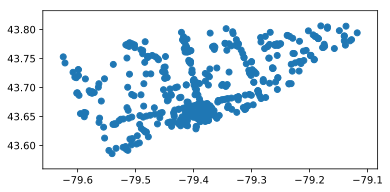

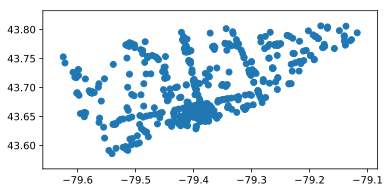

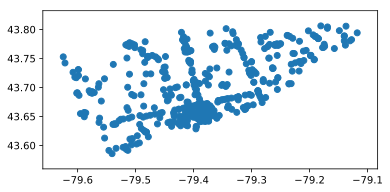

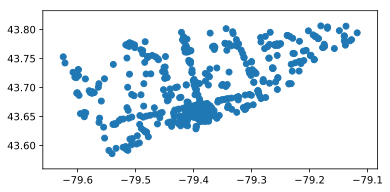

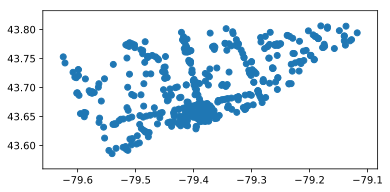

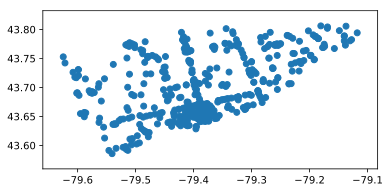

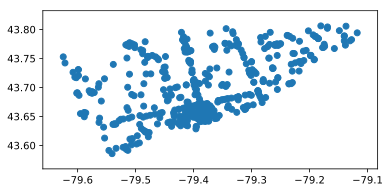

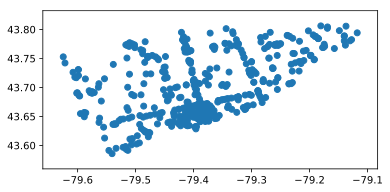

In [26]:
# iterate through possible demand ratios, optimize and draw maps
counter = 0
for demand_ratio in list_demand_ratio:    
    print('demand ratio = ', demand_ratio)
    main_map_generater(demand_ratio, df_demand, df_parking, cluster_list) 
    print('progress: ', counter)
    counter += 1